
# Проект "Промышленность"

<b>Задача бизнеса:</b> оптимизировать производственные расходы.
Металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.

<b>Описание технологического процесса от заказчика</b>:
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн.  Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
В сталь добавляются куски сплава из бункера для сыпучих материалов или проволоку.
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

<b>Данные</b>
Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

<b>Цель работы</b>: предсказать температуру стали (задача регрессии:).

In [1]:
!pip install shap

In [2]:
#Загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score)
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import (
    LinearRegression,
    RidgeCV)
from lightgbm import LGBMRegressor

from sklearn.metrics import (
    mean_absolute_error,
    make_scorer)

from tensorflow.keras.layers import Dense, Conv1D, Flatten, AvgPool1D, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras

import shap
shap.initjs()

## Функции, используемые в проекте

In [3]:
def data_info(data, name): # Вывод информации о  данных
  print(name)
  print(data.info())
  print(data.describe())

In [4]:
def get_redundant_pairs(df):# для определния сильно коррелирующих признаков
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [5]:
#функция для поиска лучшей модели
def find_best(type_model, CV,features_train, target_train, parameters):
    model = type_model()
    score_MSE  = make_scorer(mean_absolute_error)
    grid_search = GridSearchCV(model, parameters, cv = CV, scoring =score_MSE)
    grid_search.fit(features_train, target_train, verbose=10000)
    return grid_search

## Исследовательский анализ данных

In [2]:
#Загрузка данных
try:
    data_arc= pd.read_csv('/content/drive/MyDrive/FP/data_arc_new.csv') # данные об электродах
    data_bulk= pd.read_csv('/content/drive/MyDrive/FP/data_bulk_new.csv') # данные о подаче сыпучих материалов (объём)
    data_bulk_time =  pd.read_csv('/content/drive/MyDrive/FP/data_bulk_time_new.csv') # данные о подаче сыпучих материалов (время)
    data_gas =  pd.read_csv('/content/drive/MyDrive/FP/data_gas_new.csv') # данные о продувке сплава газом
    data_temp = pd.read_csv('/content/drive/MyDrive/FP/data_temp_new.csv') # результаты измерения температуры
    data_wire = pd.read_csv('/content/drive/MyDrive/FP/data_wire_new.csv') # данные о проволочных материалах (объём)
    data_wire_time = pd.read_csv('/content/drive/MyDrive/FP/data_wire_time_new.csv') # данные о проволочных материалах (время).
except OSError: 
    try:
        data_arc = pd.read_csv('data_arc_new.csv')
        data_bulk = pd.read_csv('data_bulk_new.csv')
        data_bulk_time = pd.read_csv('data_bulk_time_new.csv')
        data_gas = pd.read_csv('data_gas_new.csv')
        data_temp = pd.read_csv('data_temp_new.csv')
        data_wire = pd.read_csv('data_wire_new.csv')
        data_wire_time = pd.read_csv('data_wire_time_new.csv')
    except OSError:
        print("Что-то не так с путем к файлу")

data_arc = pd.read_csv('/datasets/data_arc_new.csv')
data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
data_gas = pd.read_csv('/datasets/data_gas_new.csv')
data_temp = pd.read_csv('/datasets/data_temp_new.csv')
data_wire = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

### Данные об электродах

In [7]:
#данные об электродах
data_info(data_arc, 'data_arc')


data_arc
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.223120          -715.479924
25%      806.000000           0.467115             0.337175
50%     1617.000000           0.599587             0.441639
75%     2429.000000           0.83007

Прпусков в данных нет, всего 14876 строк, 5 столбцов.


Если посмотреть на минимум в столбце реактивной мощност, а также на максимальные, и медианные значения - видно что -715 выбивается из данных. 
Если у нас контур: электроды - ковш со сплавом, то нагрузка имеет индуктивный характер, а значит реактивная мощность должна быть положительной. Проверим сколько данных имеют отрицательную реактивную мощность:

In [8]:
data_arc[data_arc['Реактивная мощность']<0]

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
9780  2116  2019-07-28 02:22:08  2019-07-28 02:23:57           0.705344   

      Реактивная мощность  
9780          -715.479924

Всего одна строка, посмотрим чем она еще отличается от других данных. Добавим в данные столбец, содержащий информацию о времени нагрева дуги:

In [9]:
data_arc['Время нагрева'] = pd.to_datetime(data_arc['Конец нагрева дугой']) - pd.to_datetime(data_arc['Начало нагрева дугой'])


In [10]:
data_arc['Время нагрева']  = data_arc['Время нагрева'].dt.total_seconds()

Еще раз опишем данные:

In [11]:
data_arc.describe()

key  Активная мощность  Реактивная мощность  Время нагрева
count  14876.000000       14876.000000         14876.000000   14876.000000
mean    1615.220422           0.662752             0.438986     171.670946
std      934.571502           0.258885             5.873485      98.186803
min        1.000000           0.223120          -715.479924      11.000000
25%      806.000000           0.467115             0.337175     107.000000
50%     1617.000000           0.599587             0.441639     147.000000
75%     2429.000000           0.830070             0.608201     214.000000
max     3241.000000           1.463773             1.270284     907.000000

In [12]:
data_arc[data_arc['Реактивная мощность']<0]

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
9780  2116  2019-07-28 02:22:08  2019-07-28 02:23:57           0.705344   

      Реактивная мощность  Время нагрева  
9780          -715.479924          109.0

В целом время нагрева в границах допустимого. Однако такая большая реактивная (отрицательная) мощность похожа на выброс. С другой стороны на температуру сплава влияет в первую очередб активная мощность (Q = UIcos(u)t = Pактивная*t).

Так как данный объект сильно исказит нам графики распределния данных, пока удалим этот выброс.

In [13]:
data_arc_1 = data_arc[data_arc['Реактивная мощность']>0]

Рассмотрим теперь распределение данных на графиках

In [14]:
data_arc_1.hist(column=['Время нагрева','Активная мощность','Реактивная мощность'] , bins = 100,figsize=(10,6))

plt.show()

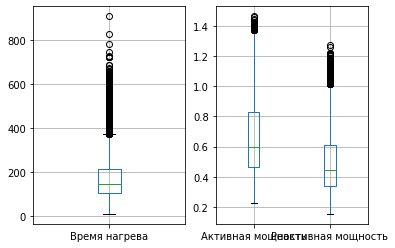

In [15]:
plt.subplot(1,2,1)
data_arc_1.boxplot(column=['Время нагрева'])
plt.subplot(1,2,2)
data_arc_1.boxplot(column=['Активная мощность','Реактивная мощность'])
plt.show()

Средне значения смещены вправо относительно медианных значений.
В тз сказано : "Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом." Может быть есть небольшое количество данных с коротким временем нагрева, но большми мощностями. Проверим это:


In [16]:
data_arc_2 = data_arc_1[data_arc_1['Активная мощность']>1]
data_arc_2.hist(column=['Время нагрева','Активная мощность','Реактивная мощность'] , bins = 100)
plt.show()

Для большой активной мощности время нагрева повторяет распределние как для полных данных.

key содержит номер партии. Проверим иттераций обработки приходится на партию.

In [17]:
unique_key = pd.DataFrame(pd.unique(data_arc['key']), columns = ['key'])
k = []
for key in unique_key['key']:
  k.append(data_arc[data_arc['key'] == key]['key'].count())

unique_key['количество иттераций'] = k

In [18]:
unique_key.describe()

key  количество иттераций
count  3214.000000           3214.000000
mean   1623.061294              4.628500
std     934.739859              1.608647
min       1.000000              1.000000
25%     817.250000              4.000000
50%    1623.500000              4.000000
75%    2431.750000              6.000000
max    3241.000000             16.000000

У каждой партии разное количество иттераций обработки.
Следовательно выбросы по номеру партии не вычислим (вдруг было несколько партий с совершненно отличной технологией обработки). 

In [19]:
unique_key['key'].count()

3214

Всего 3214 партий

#### Вывод по данным об электродах

1. Пропусков в данных нет. Всего 14876 строк, 5 столбцов (номер партии, дата начала нагрева, дата окончания нагрева, активная, реактивная мощность).
2. В данных есть 1 выброс в столбце реактивной мощности (-715). Однако мы решаем задачу определить температуру нагрева, на нее влияет выделяемая мощность в образце - необходимо использовать активную мощность.
3.  Датасет с положительной скошенностью, но объяснить это этапом обработки (первое добавление легирующих материалов) не удалось. 
4. Каждая партия имеет разное количество иттераций обработки.Всего партий 3214.
5. Для последующего анализа предлагается использовать столбцы с данными: номер партии, активная мощность, время нагрева дуги (конец нагрева - начало нагрева). 

### Данные о подаче сыпучих материалов (объём)

In [20]:
data_info(data_bulk, 'data_bulk')

data_bulk
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
               key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000 

In [21]:
print('Уникальных номеров партий', len(pd.unique(data_bulk['key'])))

Уникальных номеров партий 3129


Есть пропуски в данных, это логично - не каждый материал добавляется в конкретную партию. Всего строк 3129 (уникальных номеров партии - тоже). В прошлой таблице (информация об электродах) уникаьных партий было 3214. В данной таблице представлены не все партии. Визуализируем распределение данных.

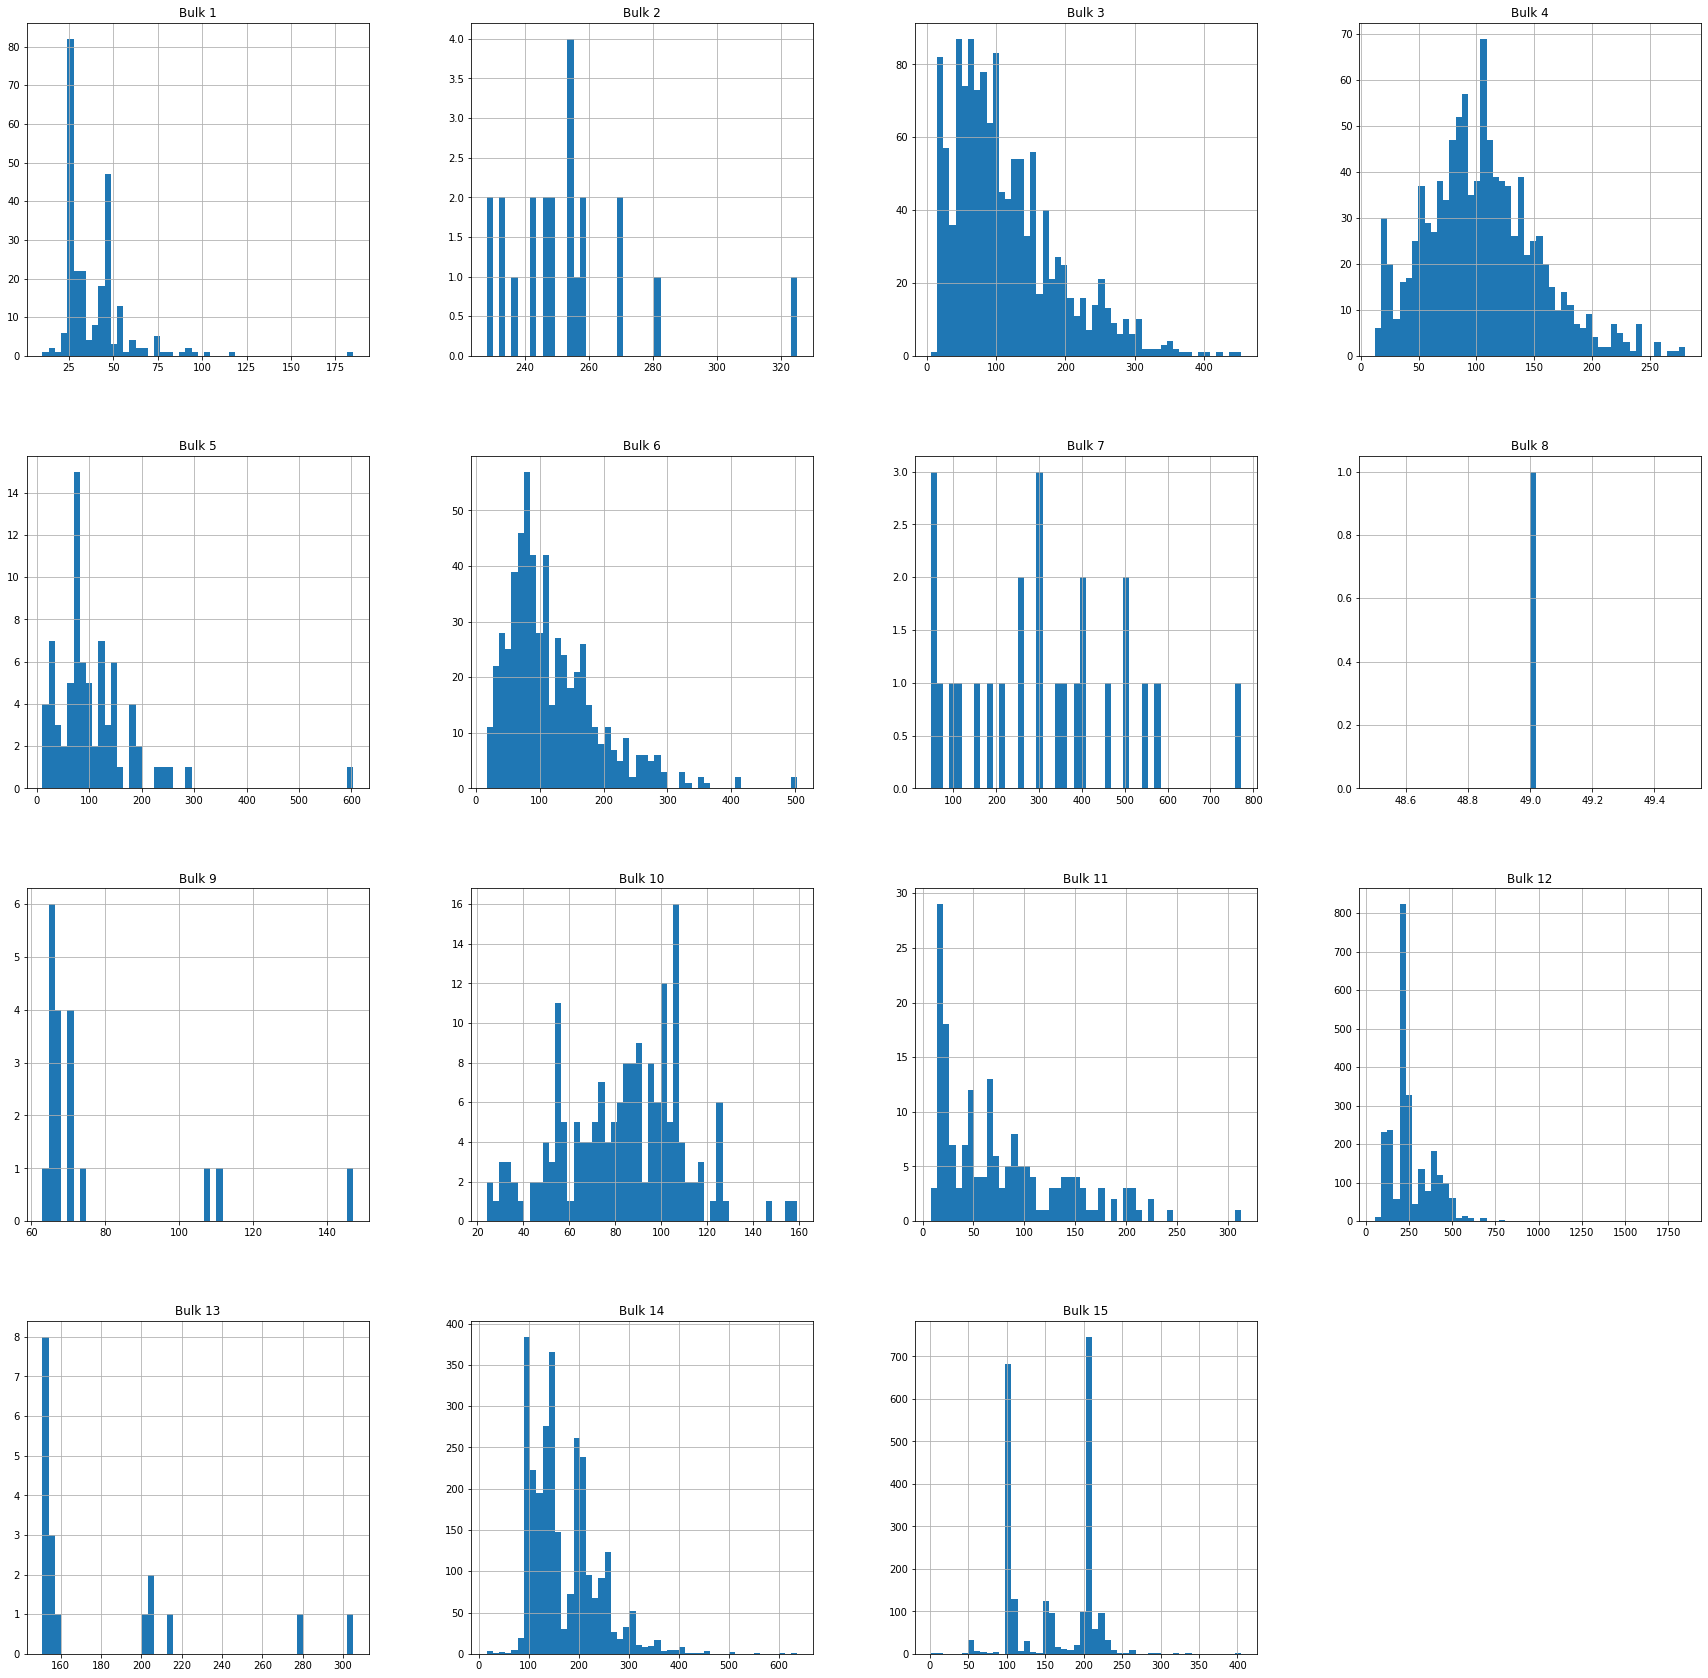

In [22]:
columns_bulk = data_bulk.drop(columns = ['key']).columns
data_bulk.hist(column = columns_bulk, figsize=(30,30), bins = 50)
plt.show()

In [23]:
data_bulk['Bulk 8'].count()

1

#### Вывод по данным об объеме сыпучих материалов

1. Всего 3219 строк, которые соотвествуют уникальной партии. Количество партий меньше, чем в данных об электродах (3214). Возможно в некторые партии не следует ничего добавлять. 
2. Данные не имеют нормального распределения, в столбце 'bulk 8' всего одно ненулевое значение. Так как эти данные характерезуют объем добавляемых материалов, а это определяется технологическим процессом - ждать от них нормальности не стоит. Поэтому данных, которые можно определить как выбросы - нет.
3. Единственное что мы могли проверить - отрицательных значений нет (нет отрицательного объема). 

### Данные о подаче сыпучих материалов (время)

In [24]:
data_info(data_bulk_time, 'data_bulk_time')

data_bulk_time
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
               key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
ma

In [25]:
print('Уникальных номеров партий', len(pd.unique(data_bulk_time['key'])))

Уникальных номеров партий 3129


Как и в таблице об объемах сыпучих материалов - строк 3129 (как и уникальных партий). 
По той же причине - есть пропуски в данных (не все материалы добавляются в сплав). Так как время подачи материалов определено технологией, искать зависимости и проверять на нормальное распределение нет смысла. Но вот проверить есть ли строки, в которх ненулевой один из столбцов в одной из таблице (data_bulk или data_bulk_time), но нулевой в другой. 
Тогда получиться что что-то добавли,но когда -неизвестно. Или известно время добавления - но ничего не добавили.  

In [26]:
#переведем данные в формат даты
columns = data_bulk_time.drop(columns = ['key']).columns
for i in columns:
  data_bulk_time[i]= pd.to_datetime(data_bulk_time[i], format = "%Y-%m-%d").dt.month # выделим месяц для удобство дальнейшего перемножения


In [27]:
k = 0
for i in columns:
  k = operator.xor(data_bulk_time[i].isnull(), data_bulk[i].isnull()).sum()
  if k>0:
    print('в столбце', i, 'есть несовпадение')
print('проверка выполнена')


проверка выполнена


В двух таблицах данные согласуются.

#### Выводы по данным о подаче сыпучих материалов (время)

Данные в таблице data_bulk_time согласуются с данными из таблицы data_bulk.

### Данные о продувке сплава газом

In [28]:
data_info(data_gas, 'data_bulk_time')

data_bulk_time
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040


In [29]:
print('Уникальных номеров партий', len(pd.unique(data_gas['key'])))

Уникальных номеров партий 3239


Cтрок 3239 (как и уникальных партий в этом датасете). 
Второй столбец содержит информацию о газе, которым продувают расплав. Построим распределение

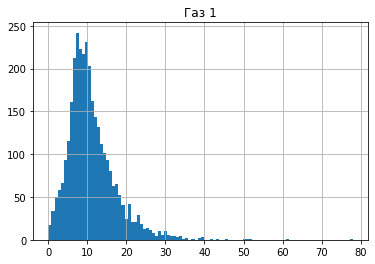

In [30]:
data_gas.hist(column = 'Газ 1', bins = 100)
plt.show()

Данные с положительной скошенностью (как и данные в таблице об электродах). 

#### Вывод по данным о продувке сплава газом

1. Количество строк 3239. Такое же количество иникальных партий. Число не совпадает с количеством партий в таблице об электродах и в таблицах о подаче сыпучих материалов.
2. Данные с положительной скошенностью

### Результаты измерения температуры

In [31]:
data_info(data_temp, 'data_temp')

data_temp
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None
                key   Температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000


In [32]:
print('Уникальных номеров партий', len(pd.unique(data_temp['key'])))

Уникальных номеров партий 3216


Всего строк 18092.
Пропуски есть в столбце температура. 

In [33]:
data_temp.head(10)

key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0
5    1  2019-05-03 11:30:38       1613.0
6    2  2019-05-03 11:34:04       1581.0
7    2  2019-05-03 11:38:40       1577.0
8    2  2019-05-03 11:46:09       1589.0
9    2  2019-05-03 11:49:38       1604.0

Время замера температуры должно коррелировать с временем добавления примесей: "Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом."

Проверим гипотезу на партии 1 (для этого  используем таблицу data_wire_time, data_bulk_time)

In [34]:
data_key_1 = np.array(data_bulk_time[data_bulk_time['key'] ==1])
data_key_1 # добавление сыпучих материалов


array([[ 1., nan, nan, nan,  5., nan, nan, nan, nan, nan, nan, nan,  5.,
        nan,  5.,  5.]])

In [35]:
data_key_1_w = np.array(data_wire_time[data_wire_time['key'] ==1])
data_key_1_w # добавление проволочных материалов

array([[1, '2019-05-03 11:06:19', nan, nan, nan, nan, nan, nan, nan, nan]],
      dtype=object)

In [36]:
data_temp.loc[data_temp['key'] ==1, 'Время замера'] # время замера температуры на первой партии

0    2019-05-03 11:02:04
1    2019-05-03 11:07:18
2    2019-05-03 11:11:34
3    2019-05-03 11:18:04
4    2019-05-03 11:25:59
5    2019-05-03 11:30:38
Name: Время замера, dtype: object

Действительно, сначала температуру проверяют - через несколько минут добавляют легирующий материал (сыпучий или проволочный). Самое последние измерение по времени - видимо контрольное измерение температуры. 

#### Выводы о результаты измерения температуры 

1. Количество партий 3216.
2. Количество строк 18092
3. Данные согласуются с таблицам data_wire_time и data_bulk_time.

###  Данные о проволочных материалах: объём и время

In [37]:
data_info(data_wire,'data_wire')

data_wire
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
               key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.

In [38]:
print('Уникальных номеров партий', len(pd.unique(data_wire['key'])))

Уникальных номеров партий 3081


In [39]:
data_info(data_wire_time,'data_wire_time')

data_wire_time
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000


In [40]:
print('Уникальных номеров партий', len(pd.unique(data_wire_time['key'])))

Уникальных номеров партий 3081


Эти данные по структуре повторяют собой данные из таблиц data_bulk и data_bulk_time. Проверим согласуются ли они.

In [41]:
#переведем данные в формат даты
columns = data_wire_time.drop(columns = ['key']).columns
for i in columns:
  data_wire_time[i]= pd.to_datetime(data_wire_time[i], format = "%Y-%m-%d").dt.month # выделим месяц для удобство дальнейшего перемножения


In [42]:
k = 0
for i in columns:
  k = operator.xor(data_wire_time[i].isnull(), data_wire[i].isnull()).sum()
  if k>0:
    print('в столбце', i, 'есть несовпадение')
print('проверка выполнена')


проверка выполнена


В двух таблицах данные согласуются.

#### Выводы по данным о проволочных материалах

1. Всего 3081 строк, которые соотвествуют уникальной партии.
2. Данные в таблицах data_wire и data_wire_time согласуются.

### Вывод

1. В таблицах разное число уникальных партий: в данных об электродах - 3214, в данных о сыпучих материалах - 3129, в данных о газе - 3239, в данных о температуре - 3216, данных о проволочных материалах - 3081. Для анализа в дальнейшем предлагается оставить данные только о тех партиях, которые встречаются в таблице об электродах, в таблице о температуре и о газе. Остальные таблицы могут не иметь данных об этих партиях: в какие-то партии возможно не добавляли сыпучие материалы, в какие-то проволку. 
2. Данные в таблицах data_bulk_time и data_bulk имеют связь 1:1 и полностью согласуются.
3. Данные в таблицах data_wire и data_wire_time имеют связь 1:1 и полностью согласуются.
4. В таблице data_arc есть выброс, имеющий реактивную мощность -715. Этот объект можно оставить, так как в целом нас интересуют активная мощность.
5. data_bulk, data_wire_time содержат информацию о времени добавления материалов к сплаву. data_temp - информацию о замере температуры. Согласно ТЗ сначала меряют температуру, потом добавляют материал - данные в таблицах это подтверждают.
6. Данные в таблицах data_arc и data_gas скошены вправо.

### План работ по моделированию

1. Решается задача регрессии: определить конечную температуру стали.
Доступные данные по температуре - начальное измерение температуры (до добавления добавок).
Объект: партия.
В обучении использовать только данные о тех партиях, которые есть во всех таблицах. При исключении каких-либо строк в таблицах(например: отрицательная реактивная мощность) исключить из рассмотрения все строки, относящиеся к этой партии. 

Удалить выбросы: отрицательную реактивную мощность, температуру стали (последний замер) ниже порога (нужно определить).

Таргет: конечное значение температуры для каждой партии (из таблицы data_temp для каждой партии взять последнюю по времени замера температуру). 
Фичи: 
- по каждой партии суммировать произведение (активная мощность*время нагрева дуги)
- начальное значение температуры сплава (из таблицы data_temp для каждой партии взять первую по времени замера температуру)
- из таблиц  data_bulk и data_wire взять все признаки (это объем добавленныъ материалов для каждой партии)
- объем газа для каждой партии.

Так как признаков получиться много (за счет таблиц data_bulk и data_wire) нужно проверить эти признаки на мультиколлинеарность. 
Скорее всего технологическим процессом обусловленно добавление каких-то материалов в связке, поэтому анализировать х по отдельности нет особого смысла. Предлагается либо использовать только часть из этих признаков, либо просуммировать те, которые сильно коррелируют (либо взять среднее).

2. Разделить данные на тестовую, и обучающую выборку (0,25 размер тестовой, random_state = 080523).

3. Обучить модели для задачи регресии (catboost, randomforest, нейронную сеть) и проверить их качество с помощью кросс-валидации. Метрика: MSE. Функция потерь - определяется в каждом конкретном случае.
4. Оценить качество модели на тестовой выборке (меньше 8,6).

## Предообработка данных

### Формирование признаков и таргетов по температуре сплава

Для начала сформируем таргеты.

Но для начала изменим формат данных в столбце 'Время замера' на datetime. 


В значениях температуры были пропуски, если пропуски в промежуточных значениях - для нас это не критично. Если в начальных и последних - данные для обработки не подходят. Заполним пропуски заглушкой, чтобы затем отфилтровать ее.
Затем формат столбца 'Температура' изменим на float

In [43]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])
data_temp['Температура'] = data_temp['Температура'].fillna('-10')
data_temp['Температура'] =data_temp['Температура'].astype(float)
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   18092 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Отлично, пропусков нет, выведем несколько строк таблицы, для проверки работы кода ниже.

In [44]:
data_temp.head(18)

key        Время замера  Температура
0     1 2019-05-03 11:02:04       1571.0
1     1 2019-05-03 11:07:18       1604.0
2     1 2019-05-03 11:11:34       1618.0
3     1 2019-05-03 11:18:04       1601.0
4     1 2019-05-03 11:25:59       1606.0
5     1 2019-05-03 11:30:38       1613.0
6     2 2019-05-03 11:34:04       1581.0
7     2 2019-05-03 11:38:40       1577.0
8     2 2019-05-03 11:46:09       1589.0
9     2 2019-05-03 11:49:38       1604.0
10    2 2019-05-03 11:55:09       1602.0
11    3 2019-05-03 12:06:44       1596.0
12    3 2019-05-03 12:13:42       1597.0
13    3 2019-05-03 12:18:46       1598.0
14    3 2019-05-03 12:25:33       1599.0
15    3 2019-05-03 12:31:04       1600.0
16    3 2019-05-03 12:35:57       1599.0
17    4 2019-05-03 12:39:27       1601.0

In [45]:
temperature = data_temp.sort_values(by=['Время замера'], ascending=True).groupby(['key']).agg(
    {'Температура':['first','last']})
temperature.head(5)

Температура        
          first    last
key                    
1        1571.0  1613.0
2        1581.0  1602.0
3        1596.0  1599.0
4        1601.0  1625.0
5        1576.0  1602.0

Действительно, проверка для партии 1 и 2 работает. Теперь удалим объекты(партии) где в нужных температурах есть пропуски(сейчас заглушки)

In [46]:
temperature.shape

(3216, 2)

В именах столбца мультииндекс, оставим толькой один

In [47]:
temperature.columns = temperature.columns.droplevel(0)
temperature.columns

Index(['first', 'last'], dtype='object')

Изначально уникальных партий было 3216 (пункт 1.5), до удаления пропусков (заглушек) - строк в таблице нужных температур - столько же.

In [48]:
temperature = temperature.query('(first>0) and (last>0)')
temperature.shape

(2477, 2)

In [49]:
temperature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   first   2477 non-null   float64
 1   last    2477 non-null   float64
dtypes: float64(2)
memory usage: 58.1 KB


Потеряли 23% данных (изначально в полной таблице было 20% пропусков, следовательно в каких-то партиях были данные по промежуточной температуре, но не было конечной или начальной).

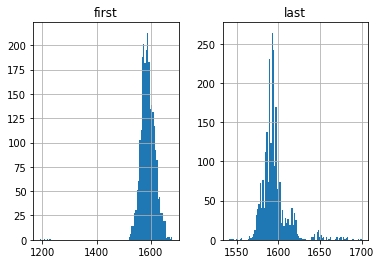

In [50]:
temperature.hist(column = ['first', 'last'], bins = 100)
plt.show()

In [51]:
temperature.boxplot(column = ['first', 'last'])
plt.show()

Чтож удалим все температру ниже 1400.

In [52]:
temperature = temperature.query('(first>1400) and (last>1400)')
temperature.shape

(2473, 2)

Удалили еще 4 объекта.

### Формирование признаков по данным об электродах

Сначала расчитаем информацию по времени нагрева дуги

In [53]:
data_arc['Время нагрева'] = (pd.to_datetime(data_arc['Конец нагрева дугой']) - pd.to_datetime(
    data_arc['Начало нагрева дугой'])).dt.total_seconds()

Теперь рассчитаем энергию, выделяемую в одну иттерацию для каждой партии:

In [54]:
data_arc['Энергия'] = data_arc['Активная мощность'] * data_arc['Время нагрева']

In [55]:
data_arc.head(5)

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  Время нагрева     Энергия  
0             0.211253          228.0   69.569640  
1             0.477438          185.0  141.646730  
2             0.430460          172.0   99.813836  
3             0.379979          365.0  189.251040  
4             0.643691          148.0  128.335684

Сгруппируем данные по партиям, энергию проссуммируем, реактивную мощность - выведем минимум (чтобы затем исключить партию с реактивной мощностью -751)

In [56]:
energy = data_arc.groupby('key').agg({
    'Энергия':'sum',
    'Реактивная мощность':'min'
})
energy.head(5)

Энергия  Реактивная мощность
key                                 
1    628.616930             0.211253
2    395.281800             0.205527
3    581.774624             0.272562
4    543.710274             0.241781
5    412.180480             0.279102

In [57]:
energy.shape

(3214, 2)

Количество партий совпадает с количеством партий в исходном датасете.

In [58]:
energy = energy.rename(columns = {'Реактивная мощность':'Реактивная'})
energy = energy.query("Реактивная > 0")
energy = energy.drop(columns = 'Реактивная')
energy.shape

(3213, 1)

Уникальное количество партий в таблице об энергии - 3213

### Формирование признаков о добавочных материалах

In [59]:
data_wire.head(5)

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [60]:
data_wire.shape

(3081, 10)

In [61]:
data_bulk.head(5)

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

In [62]:
data_bulk.shape

(3129, 16)

In [63]:
materials = data_wire.merge(data_bulk, how='inner', on='key')
materials.head(5)

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  ...  Bulk 6  Bulk 7  Bulk 8  Bulk 9  Bulk 10  Bulk 11  Bulk 12  \
0     NaN  ...     NaN     NaN     NaN     NaN      NaN      NaN    206.0   
1     NaN  ...     NaN     NaN     NaN     NaN      NaN      NaN    206.0   
2     NaN  ...     NaN     NaN     NaN     NaN      NaN      NaN    205.0   
3     NaN  ...     NaN     NaN     NaN     NaN      NaN      NaN    207.0   
4     NaN  ...     NaN     NaN     NaN     NaN      NaN      NaN    203.0   

   Bulk 13  Bulk 14  Bulk 15  
0      NaN    150.0    154.0  
1      NaN    149.0    154.0  
2      NaN    152.0    153.0  
3      NaN    153.0    154.0  
4      NaN    151.0    152.0  

[5 rows x 25 columns]

In [64]:
materials.shape

(3025, 25)

Данные объеденены в таблицу материалов, всего строк (объектов) осталось 3025. 

### Объеденение итоговой таблицы

In [65]:
#Добавим столбцы по которм будем объединять данные
energy['key'] = energy.index 
temperature['key'] = temperature.index

In [66]:
energy = energy.reset_index(drop = True)
temperature = temperature.reset_index(drop = True)

In [67]:
data1= materials.merge(energy, how='inner', on='key')

In [68]:
data2 = data1.merge(temperature, how='inner', on='key')

In [69]:
data2.shape

(2326, 28)

In [70]:
data2.head()

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  ...  Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  \
0     NaN  ...     NaN      NaN      NaN    206.0      NaN    150.0    154.0   
1     NaN  ...     NaN      NaN      NaN    206.0      NaN    149.0    154.0   
2     NaN  ...     NaN      NaN      NaN    205.0      NaN    152.0    153.0   
3     NaN  ...     NaN      NaN      NaN    207.0      NaN    153.0    154.0   
4     NaN  ...     NaN      NaN      NaN    203.0      NaN    151.0    152.0   

      Энергия   first    last  
0  628.616930  1571.0  1613.0  
1  395.281800  1581.0  1602.0  
2  581.774624  1596.0  1599.0  
3  543.710274  1601.0  1625.0  
4  412.180480  1576.0  1602.0  

[5 rows x 28 columns]

В итоговой таблице осталось 2306 строк 

Заполним пропуски нулями:

In [71]:
data2 = data2.fillna(0)
data2.head(5)

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
1    2  96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2    3  91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3    4  89.063515  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4    5  89.238236  9.11456     0.0     0.0     0.0     0.0     0.0     0.0   

   Wire 9  ...  Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  \
0     0.0  ...     0.0      0.0      0.0    206.0      0.0    150.0    154.0   
1     0.0  ...     0.0      0.0      0.0    206.0      0.0    149.0    154.0   
2     0.0  ...     0.0      0.0      0.0    205.0      0.0    152.0    153.0   
3     0.0  ...     0.0      0.0      0.0    207.0      0.0    153.0    154.0   
4     0.0  ...     0.0      0.0      0.0    203.0      0.0    151.0    152.0   

      Энергия   first    last  
0  628.616930  1571.0  1613.0  
1  395.281800  1581.0  1602.0  
2  581.774624  1596.0  1599.0  
3  543.710274  1601.0  1625.0  
4  412.180480  1576.0  1602.0  

[5 rows x 28 columns]

### Разделение данных на обучающую и тестовую выборку

In [72]:
train, test = train_test_split(data2, test_size=0.25, shuffle=True,random_state=80523)

In [73]:
train_features = train.drop(columns = ['last', 'key'])
test_features = test.drop(columns = ['last', 'key'])

train_target = train['last']
test_target = test['last']

### Проверка на корреляцию 

Проверим данные на корреляцию.

In [74]:
print("Top Absolute Correlations")
сorr_columns = get_top_abs_correlations(train,28)
print(сorr_columns)

Top Absolute Correlations
Wire 8   Bulk 9     0.990238
Wire 4   Bulk 7     0.790521
         Bulk 2     0.789271
Bulk 2   Bulk 7     0.742481
Wire 4   Wire 7     0.684382
Bulk 12  Bulk 15    0.629237
Wire 6   Bulk 2     0.617264
Wire 4   Wire 6     0.559961
Wire 6   Bulk 7     0.552312
Bulk 12  Bulk 14    0.463834
Wire 7   Bulk 2     0.445317
Bulk 12  Энергия    0.397677
Bulk 14  Энергия    0.396126
Bulk 2   Bulk 5     0.395615
Wire 7   Bulk 7     0.393911
Энергия  first      0.356782
Wire 6   Wire 7     0.345451
Bulk 5   Bulk 7     0.341068
Wire 1   last       0.333338
Wire 4   Bulk 5     0.324973
first    last       0.294514
Wire 1   Bulk 4     0.294008
Bulk 3   Bulk 4     0.293113
Bulk 1   Bulk 12    0.279336
         Bulk 2     0.277948
Wire 1   first      0.277269
Wire 2   Bulk 4     0.270555
Bulk 15  last       0.267083
dtype: float64


In [75]:
#Выведем столбцы с высокой корреляцией
t = pd.DataFrame(сorr_columns[сorr_columns>=0.9].index)
columns_with_corr = []
for i in  range(len(t)):
    columns_with_corr.append(t.iloc[i,0][0])
columns_with_corr 

['Wire 8']

Это тот самый признак, где всего одно значение. Кажется он действительно не будет информативен

In [80]:
import seaborn as sns
plt.figure(figsize=(20, 12))
plt.title('Корреляция признаков')
sns.heatmap(data2.corr(method='spearman'), annot = True, cmap="coolwarm")
plt.show()

In [76]:
train_features = train_features.drop(columns = columns_with_corr, axis = 1)
test_features = test_features.drop(columns = columns_with_corr, axis = 1)

In [77]:
columns_features = train_features.columns
columns_features

Index(['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7',
       'Wire 9', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15', 'Энергия', 'first'],
      dtype='object')

### Масштабирование данных

In [78]:
scaler = StandardScaler().fit(train_features)

train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

## Обучение моделей

### CatBoost

In [81]:
%%time
parameters = {'iterations': [150, 300, 500],
        'learning_rate': [0.03,0.05, 0.1],
        'depth': [None, 2, 4, 8],
        'l2_leaf_reg': [0.1, 1,  5]     

              
        
}
    
model_cat = find_best(CatBoostRegressor, 5,train_features, train_target, parameters)

0:	learn: 11.1105546	total: 50.6ms	remaining: 7.54s
149:	learn: 8.0257946	total: 457ms	remaining: 0us
0:	learn: 10.7301986	total: 5.58ms	remaining: 831ms
149:	learn: 7.7202560	total: 462ms	remaining: 0us
0:	learn: 11.3712694	total: 7.97ms	remaining: 1.19s
149:	learn: 8.0340128	total: 399ms	remaining: 0us
0:	learn: 11.1559424	total: 2.78ms	remaining: 414ms
149:	learn: 8.0970215	total: 422ms	remaining: 0us
0:	learn: 11.2964784	total: 2.53ms	remaining: 377ms
149:	learn: 8.1174743	total: 431ms	remaining: 0us
0:	learn: 11.1433405	total: 918us	remaining: 137ms
149:	learn: 8.9810843	total: 105ms	remaining: 0us
0:	learn: 10.7462015	total: 884us	remaining: 132ms
149:	learn: 8.6608314	total: 95.5ms	remaining: 0us
0:	learn: 11.4024445	total: 964us	remaining: 144ms
149:	learn: 9.0363167	total: 110ms	remaining: 0us
0:	learn: 11.1803706	total: 619us	remaining: 92.4ms
149:	learn: 9.0503529	total: 98.3ms	remaining: 0us
0:	learn: 11.3262099	total: 964us	remaining: 144ms
149:	learn: 9.0575681	total: 98.

In [82]:
model_cat.best_score_

6.923355180983546

In [83]:
model_cat.best_params_

{'depth': 2, 'iterations': 150, 'l2_leaf_reg': 5, 'learning_rate': 0.03}

### LinearRegression

In [84]:
np.mean(cross_val_score(LinearRegression(), 
                        train_features, train_target, 
                        cv = 5, scoring = make_scorer(mean_absolute_error)))

6.634863193244511

### LightGBM

In [ ]:
%%time    
parameters = {
    'max_depth' :[10,5],
    'learning_rate': [0.1, 0.5],
    'boosting_type': ['gbdt', 'rf'],
    'random_state': [80523]}
model_lgbm = find_best(LGBMRegressor, 5,train_features, train_target, parameters)

In [ ]:
model_lgbm.best_score_

In [ ]:
model_lgbm.best_params_

### Нейронная сеть

In [105]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=150, input_dim=train_features.shape[1], 
                             activation='relu'))
model.add(keras.layers.Dense(units=100, activation='relu'))
model.add(keras.layers.Dense(units=50))
model.add(keras.layers.Dense(units=25))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mse', optimizer='adam', metrics = ['mae'])

model.fit(train_features, train_target, epochs=100, verbose=100)
pred =model.predict(train_features)
mean_absolute_error(train_target, pred)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

10.087115226535623

## Проверка тестовой модели

### Анализ модели

Лучшая модель catboostregression с параметрами {'depth': 2, 'iterations': 150, 'l2_leaf_reg': 5, 'learning_rate': 0.03}.
Рассмотрим эту модель подробнее:

In [80]:
explainer = shap.TreeExplainer(model_cat.best_estimator_)
shap_values = explainer.shap_values(train_features)

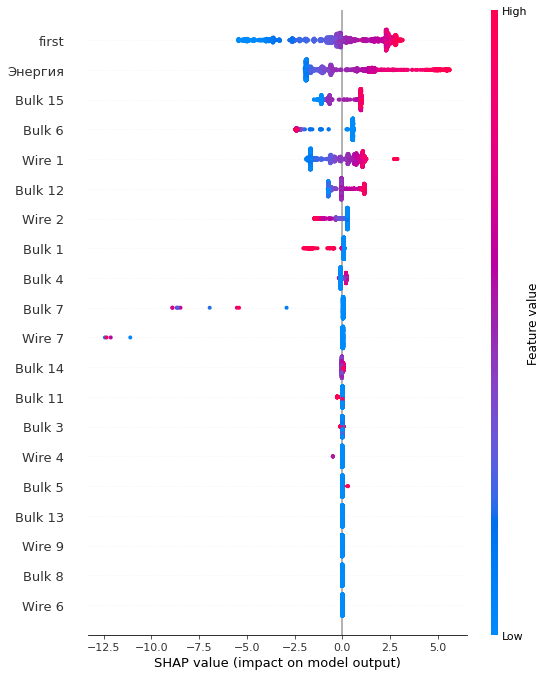

In [81]:
# summarize the effects of all the features
train_features_with_columns = pd.DataFrame(train_features, columns = columns_features)
shap.summary_plot(shap_values, train_features_with_columns)

Выше приведен график распределение признаков по важности, показывает то - какие признаки больше всего влияют на прогноз модели.
Неудивительно, что первыми идут признаки: начальной температуры и энергии (согласуется с физическими законами). Высокая начальная температура и высокое значение энергии дают на выходе более высокое значение температуры сплава.
Далее видим влияние уже добавок, при этом только около 6 добавок влияют на распределение, остальные добавки почти не сдвигают прогноз модели.

In [82]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[80,:], train_features[80,:])

In [83]:
#Предсказание модели для этого объекта
model_cat.best_estimator_.predict(train_features[80,:])

1592.1682458221726

Показан средний вывод модели по переданному обучающему набору данных к выводу модели для конкретного примера. Функции, повышающие прогноз, показаны красным цветом, а те, которые снижают прогноз, — синим.
Так температура предсказанная 1592.17, средний вывод модели 1593. 

Если мы возьмем много объяснений, таких как показанное выше, повернем их на 90 градусов, а затем сложим горизонтально, мы увидим объяснения для всего набора данных (комментарий из документации к библиотеке shap):

In [84]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, train_features)

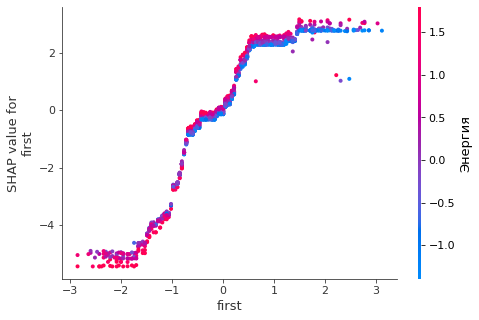

In [85]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('first', shap_values, train_features_with_columns)

Показано влияние отдельной функции (первичной температуры) на выход модели.
Вертикальная дисперсия при одном значении первичной температуры представляет эффекты взаимодействия с другими функциями. Чтобы помочь выявить эти взаимодействия, dependency_plot автоматически выбирает другую функцию для раскрашивания. В этом случае раскрашивание по энергии.
В целом влияние энергии и первичной температуры равнозначно.

### Тестирование модели

In [86]:
model_best = model_cat.best_estimator_
best_param = model_cat.best_params_
prediction_test = model_best.predict(test_features)
mean_absolute_error_test = mean_absolute_error(test_target, prediction_test)

In [87]:
mean_absolute_error_test

6.773964418510793

МАЕ = <8.6 цель достигнута. 

## Вывод

<b>Задача бизнеса:</b> оптимизировать производственные расходы, предсказав финальную температуру сплава перед розливом.

<b>Данные</b>
Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

<b>Разделы отчета:</b>
1. Исследовательский анализ данных.
2.Предообработка данных.
3.Обучение модели.
4. Проверка качества модели на тестовых данных. 

В первом разделе были получены следующие результаты:
- В таблицах разное число уникальных партий.
- Данные в таблицах data_bulk_time и data_bulk имеют связь 1:1 и полностью согласуются.
- Данные в таблицах data_wire и data_wire_time имеют связь 1:1 и полностью согласуются.
- В таблице data_arc есть выброс, имеющий реактивную мощность -715.
- data_bulk, data_wire_time содержат информацию о времени добавления материалов к сплаву. data_temp - информацию о замере температуры. Согласно ТЗ сначала меряют температуру, потом добавляют материал - данные в таблицах это подтверждают.
- Данные в таблицах data_arc и data_gas скошены вправо.

На снове полученных данных был выполнен следующий <b>план действий</b>:
1. В обучении использовались только данные о тех партиях, которые есть во всех таблицах (23% данных было исключено). 

При исключении  строк в таблицах(например: отрицательная реактивная мощность) исключены из рассмотрения все строки, относящиеся к этой партии. 

Удалены выбросы: отрицательная реактивная мощность, температура стали (последний замер) ниже порога 1400.
Всего было удалено 5 партий: 4 из-за низкой температуры плавки (возможно это отдельные партии с другими свойствами) и 1 из-за отрицательной большой реактивной мощности (возможно в этом случае не произошло погружения электродов в расплав, данную иттерацию для обучения использовать было некорректно, вся партия была удалена из рассмотрения).

Таргет: конечное значение температуры для каждой партии (из таблицы data_temp для каждой партии - последняя по времени замера температуру). 

Фичи: 
- по каждой партии суммировано произведение (активная мощность*время нагрева дуги)
- начальное значение температуры сплава (из таблицы data_temp для каждой партии - первую по времени замера температуру)
- из таблиц  data_bulk и data_wire взяты все признаки (это объем добавленныъ материалов для каждой партии)
- объем газа для каждой партии.

Признаки были проверены на мультиколлинеарность. Был удален признак 'Wire 8'.

2. Разделены данные на тестовую, и обучающую выборку (0,25 размер тестовой, random_state = 080523).

3. Обучены модели для задачи регресии (catboost, randomforest, полносвязная нейронная сеть) и  их качество оценено с помощью кросс-валидации. Метрика: MАE. 
Лучше всего себя показала модель catboost с параметрами:'depth': 2, 'iterations': 150, 'l2_leaf_reg': 5, 'learning_rate': 0.03. MAE = 6.9.

В пункте 5.1 дан график важности признаков для предсказания модели. Неудивительно, что первыми идут признаки: начальной температуры и энергии (согласуется с физическими законами). Высокая начальная температура и высокое значение энергии дают на выходе более высокое значение температуры сплава.
Далее видим влияние уже добавок, при этом только около 6 добавок влияют на распределение, остальные добавки почти не сдвигают прогноз модели.



4. MAE на тестовой выборке - 6.7. Цель работы достигнута.